In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.transforms import v2
from torchsummary import summary

torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(28, 28), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomInvert(), # инвертирование цветов
    v2.ToImage(),  # Преобразование в изображение
    v2.ToDtype(torch.float32, scale=True),  # Преобразование в тензор с масштабированием
    v2.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='../data', train=True, download=True, transform=transforms)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size=1024//2, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1024//2, shuffle=False)

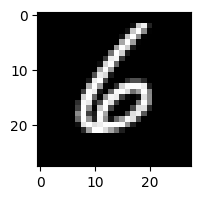

In [7]:
for images, labels in train_loader:
    plt.figure(figsize=(2, 2))
    plt.imshow(images[-1, :][0], cmap='gray')
    break

In [15]:
class MNISTClassification(nn.Module):
    def __init__(self):
        super(MNISTClassification, self).__init__()
        self.linear = nn.Linear(28*28, 10)
    
    def forward(self, image):
        out = image.view(-1, 28*28)
        out = self.linear(out)
        return out

mnist_model = MNISTClassification().to(device)
criterion = nn.CrossEntropyLoss()
optimizer  = optim.SGD(mnist_model.parameters(), lr=0.05)

summary(mnist_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [9]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    mnist_model.train()
    total_loss = 0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f'Epoch [{epoch+1:>2}/{num_epochs}]') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = mnist_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'mnist loss': f'{loss.item():.4f}'})
            pbar.update(1)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1:>2}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [ 1/10]: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s, mnist loss=0.4941]


Epoch [ 1/10], Loss: 0.7636, Accuracy: 78.35%


Epoch [ 2/10]: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s, mnist loss=0.3274]


Epoch [ 2/10], Loss: 0.4273, Accuracy: 88.25%


Epoch [ 3/10]: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s, mnist loss=0.3597]


Epoch [ 3/10], Loss: 0.3818, Accuracy: 89.35%


Epoch [ 4/10]: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s, mnist loss=0.2425]


Epoch [ 4/10], Loss: 0.3583, Accuracy: 89.90%


Epoch [ 5/10]: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s, mnist loss=0.2942]


Epoch [ 5/10], Loss: 0.3443, Accuracy: 90.30%


Epoch [ 6/10]: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s, mnist loss=0.3478]


Epoch [ 6/10], Loss: 0.3350, Accuracy: 90.53%


Epoch [ 7/10]: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s, mnist loss=0.2872]


Epoch [ 7/10], Loss: 0.3267, Accuracy: 90.77%


Epoch [ 8/10]: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s, mnist loss=0.3206]


Epoch [ 8/10], Loss: 0.3214, Accuracy: 90.89%


Epoch [ 9/10]: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s, mnist loss=0.2767]


Epoch [ 9/10], Loss: 0.3163, Accuracy: 90.98%


Epoch [10/10]: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s, mnist loss=0.3371]

Epoch [10/10], Loss: 0.3121, Accuracy: 91.13%


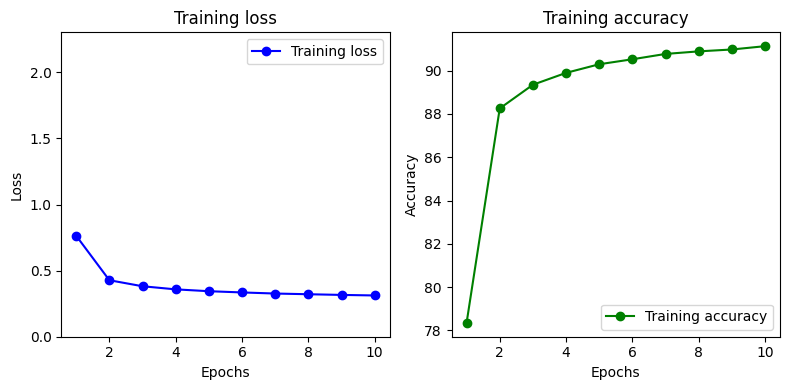

In [10]:
# Визуализация
epochs = range(1, num_epochs+1)

plt.figure(figsize=(8, 4))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, (-np.log(1/10)))
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'go-', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

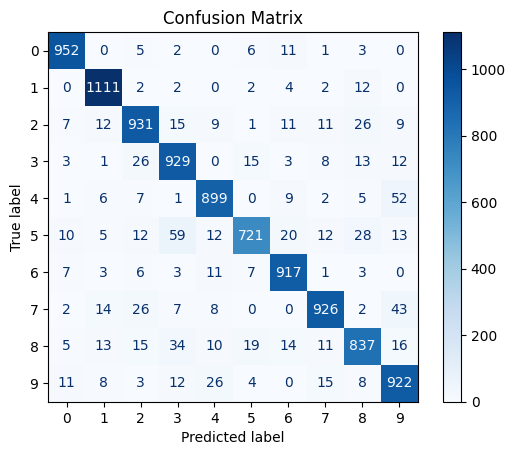

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.90      0.90      0.90      1032
           3       0.87      0.92      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.93      0.81      0.87       892
           6       0.93      0.96      0.94       958
           7       0.94      0.90      0.92      1028
           8       0.89      0.86      0.88       974
           9       0.86      0.91      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [11]:
# Оценка модели на тестовых данных
mnist_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mnist_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Матрица неточностей
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Отчет о классификации
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))